Non-Stacked


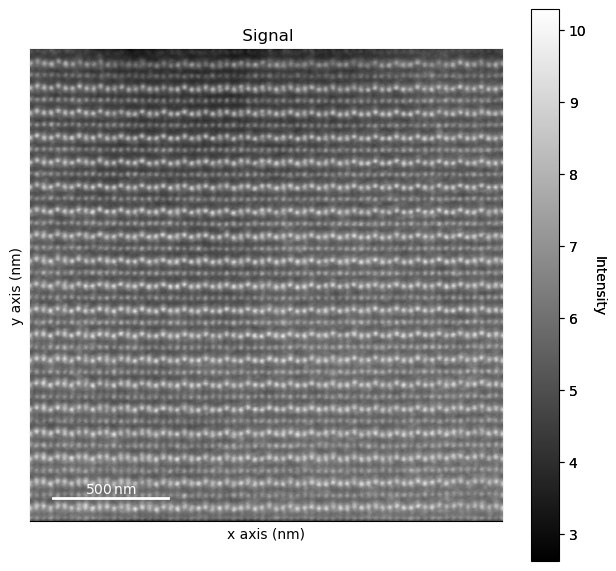

In [1]:
import skimage
import matplotlib.pyplot as plt
import hyperspy.api as hs
import sys
sys.path.append('../..')
import util.crop

stack_num = 0 # The index of stacked image

# Change the name of s_load to load different plots.
# Note that some datasets are in stacks and their data will be 3-dimension,
# where the first dimention is the index of a single stacked image. We want to
# look at one image each of the time, so for those stacked images, please change
# stack_num to view different images.

# Load one file at a time.
# These commented files are some that I want think could be reevaluated later for references.
s_load = hs.load('../../data/images/Jaume LFO/HAADF_Buena.dm3')

if len(s_load.data.shape) == 2: # Non-stacked
    print("Non-Stacked")
    s = s_load
else: # Stacked, where s_load.data.shape = 3
    print("Stacked")
    s = s_load.inav[stack_num]

# Plot the image in pixels. We can plot in nanometers by simply doing s.plot().
import copy
s_copy = copy.deepcopy(s)
for ax in s_copy.axes_manager.signal_axes:
    ax.scale = 1.0
    ax.offset = 0.0

plt.close()
s_copy.plot()

In [2]:
import scipy.signal
import numpy as np

left_bound = 40 # TUNE THIS
right_bound = 2040 # TUNE THIS
start_pixel = 40 # TUNE THIS
end_pixel = 2040 # TUNE THIS
# window_height_nm = None

crop = util.crop.Crop(s, left_bound, right_bound, start_pixel, end_pixel)

In [3]:
crop.build_grid_dict()
crop.get_atom_positions()
# crop.refine_atom_positions()

crop.get_nn_intensities()
crop.get_nn_displacements()
crop.get_atom_types()

In [4]:
from sklearn.decomposition import PCA

intensity_vectors = []

for patch in crop.grid.values():
    # Filter for 'Lu' and ensure data exists
    if patch.nn_intensity_differences is not None and patch.atom_type == 'Lu':
        intensity_vectors.append(patch.nn_intensity_differences)

X = np.array(intensity_vectors)

Explained Variance Ratio per component: [0.4514158  0.33451755 0.12810839 0.08595826]
Cumulative Variance: [0.4514158  0.78593335 0.91404174 1.        ]


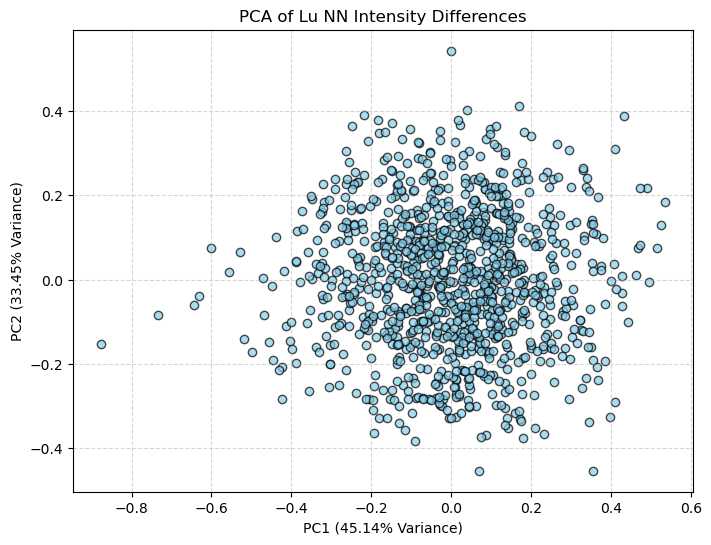

In [5]:
pca = PCA(n_components=None) 
X_pca = pca.fit_transform(X)

print("Explained Variance Ratio per component:", pca.explained_variance_ratio_)
print("Cumulative Variance:", np.cumsum(pca.explained_variance_ratio_))

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, color='skyblue', edgecolor='black')
plt.title('PCA of Lu NN Intensity Differences')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Variance)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

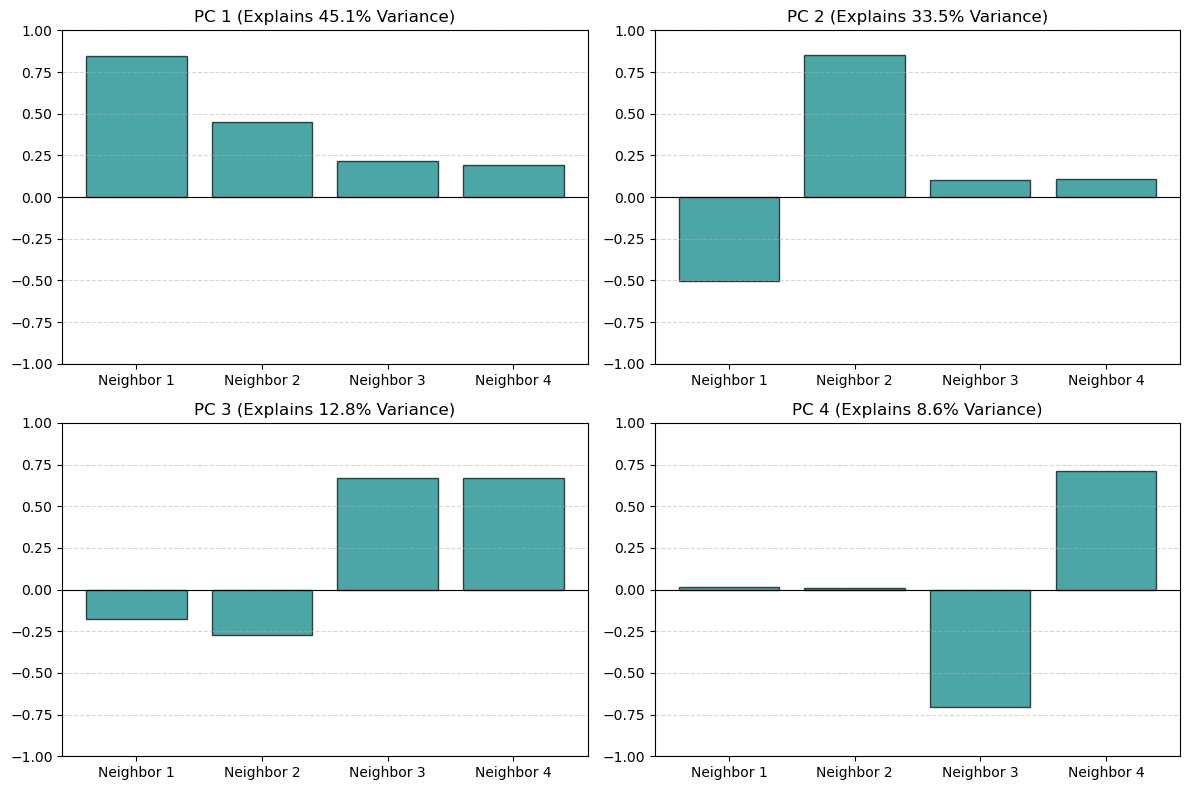

Component Loadings (Rows=PC, Cols=Neighbor):
[[ 0.8463429   0.44926497  0.21411951  0.18978283]
 [-0.50247877  0.85154723  0.104678    0.10688738]
 [-0.17601126 -0.27015787  0.66892999  0.66975177]
 [ 0.01545399  0.00655885 -0.70407956  0.70992262]]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Setup Data (Same as before)
lu_vectors = []
for patch in crop.grid.values():
    if patch.nn_intensity_differences is not None and patch.atom_type == 'Lu':
        lu_vectors.append(patch.nn_intensity_differences)

X = np.array(lu_vectors)

# 2. Run PCA with all 4 components
pca = PCA(n_components=4)
pca.fit(X)

# 3. Plot the Loadings (The "Recipe" for each Component)
feature_names = ['Neighbor 1', 'Neighbor 2', 'Neighbor 3', 'Neighbor 4']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    # pca.components_[i] contains the 4 weights for PC_i
    weights = pca.components_[i]
    
    # Create bar chart
    ax.bar(feature_names, weights, color='teal', edgecolor='black', alpha=0.7)
    
    # Formatting
    variance = pca.explained_variance_ratio_[i]
    ax.set_title(f'PC {i+1} (Explains {variance:.1%} Variance)')
    ax.set_ylim(-1.0, 1.0) # Eigenvectors are normalized, this keeps scale consistent
    ax.axhline(0, color='black', linewidth=0.8)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Optional: Print exact values if you need to debug specific numbers
print("Component Loadings (Rows=PC, Cols=Neighbor):")
print(pca.components_)

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import numpy as np
from sklearn.decomposition import PCA

def plot_pca_grid(crop, pc_component=3, atom_type='Lu'):
    """
    Plots a 2D map of the grid colored by a specific PCA component score.
    
    Args:
        pc_component: The PCA component number to plot (1, 2, 3, or 4).
        atom_type: The atom type to filter for (e.g., 'Lu').
    """
    
    # --- Step 1: Collect Data & Run PCA ---
    valid_patches = []
    vectors = []
    
    # Collect vectors and keep track of which patch owns them
    for patch in crop.grid.values():
        if (patch.nn_intensity_differences is not None 
            and patch.atom_type == atom_type):
            
            valid_patches.append(patch)
            vectors.append(patch.nn_intensity_differences)
            
    if len(vectors) == 0:
        print(f"No valid data found for atom type {atom_type}")
        return

    # Run PCA
    X = np.array(vectors)
    pca = PCA(n_components=4)
    X_pca = pca.fit_transform(X)
    
    # Select the specific component column (adjusting 1-based index to 0-based)
    # PC3 is at index 2
    scores = X_pca[:, pc_component - 1]
    
    # Create a mapping: Patch Object -> Score
    # We zip the list of patches we saved with their calculated scores
    patch_score_map = {patch: score for patch, score in zip(valid_patches, scores)}

    # --- Step 2: Setup Plotting (diverging colormap) ---
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(crop.roi, cmap='gray', alpha=0.5) # Show background image faintly

    # Determine Range for Color Normalization
    # We use a centered norm because PCA scores are deviations from 0
    max_abs = np.max(np.abs(scores))
    norm = mcolors.Normalize(vmin=-max_abs, vmax=max_abs)
    
    # 'coolwarm' or 'bwr' are best for PCA: 
    # Red = High Positive, Blue = High Negative, White = Zero (Mean)
    cmap = cm.get_cmap('coolwarm') 

    # --- Step 3: Draw the Grid ---
    def _get_edges(patch):
        col_edges = patch.roi_col_edges
        row_edges = patch.roi_row_edges
        x0, x1 = float(col_edges[0]), float(col_edges[1])
        y0, y1 = float(row_edges[0]), float(row_edges[1])
        return x0, x1, y0, y1

    def _draw_box(patch, color, fill, z):
        edges = _get_edges(patch)
        if edges is None: return
        x0, x1, y0, y1 = edges
        wr = x1 - x0
        hr = y1 - y0
        rect = Rectangle((x0, y0), wr, hr, edgecolor=color, facecolor=color, 
                         fill=fill, linewidth=1, alpha=0.8, zorder=z)
        ax.add_patch(rect)

    for patch in crop.grid.values():
        # Only color patches that were part of the PCA
        if patch in patch_score_map:
            score = patch_score_map[patch]
            color = cmap(norm(score))
            _draw_box(patch, color=color, fill=True, z=2)
        else:
            # Optional: Draw excluded atoms (e.g. Fe) as hollow grey boxes
            # _draw_box(patch, color='grey', fill=False, z=1)
            pass

    # --- Step 4: Formatting ---
    explained_var = pca.explained_variance_ratio_[pc_component - 1]
    ax.set_title(f'Spatial Map of PC {pc_component} (Explains {explained_var:.1%} var)\nAtom Type: {atom_type}')
    
    # Add Colorbar
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label(f'PC {pc_component} Score (Deviation from Mean)')

    ax.set_xlabel('i (x)')
    ax.set_ylabel('j (y)')
    plt.tight_layout()
    plt.show()

/var/folders/_w/v56drf556mx31xc17rw2g1yh0000gn/T/ipykernel_23813/234458908.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


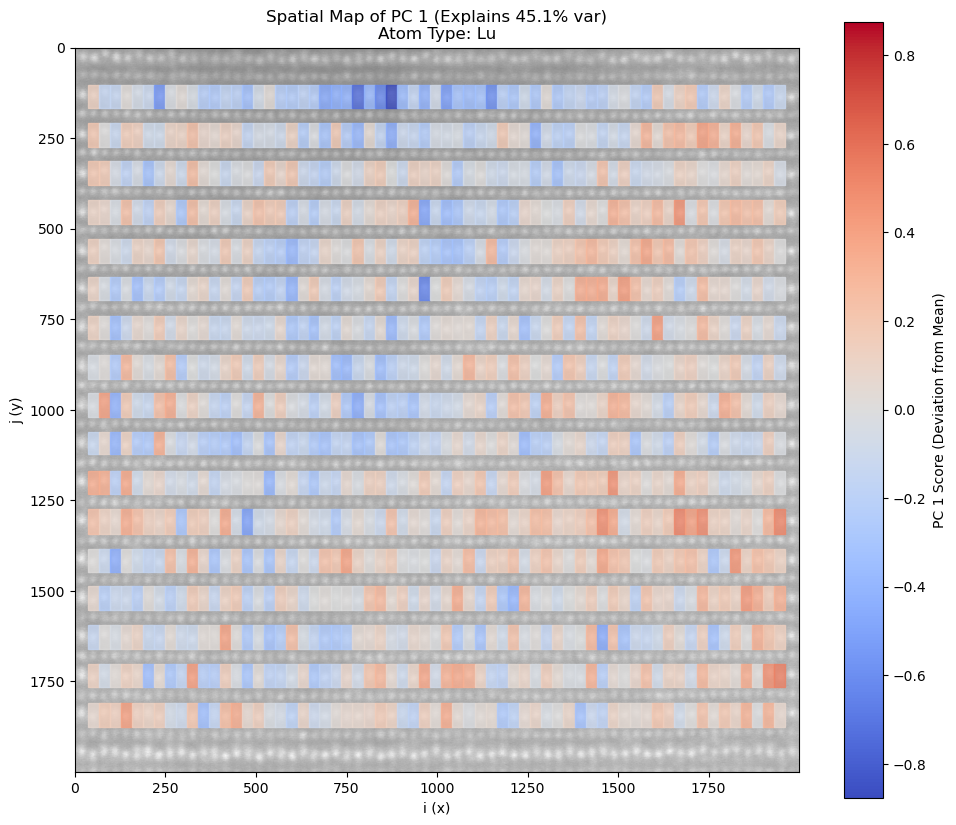

In [8]:
plot_pca_grid(crop, pc_component=1, atom_type='Lu')

/var/folders/_w/v56drf556mx31xc17rw2g1yh0000gn/T/ipykernel_23813/234458908.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


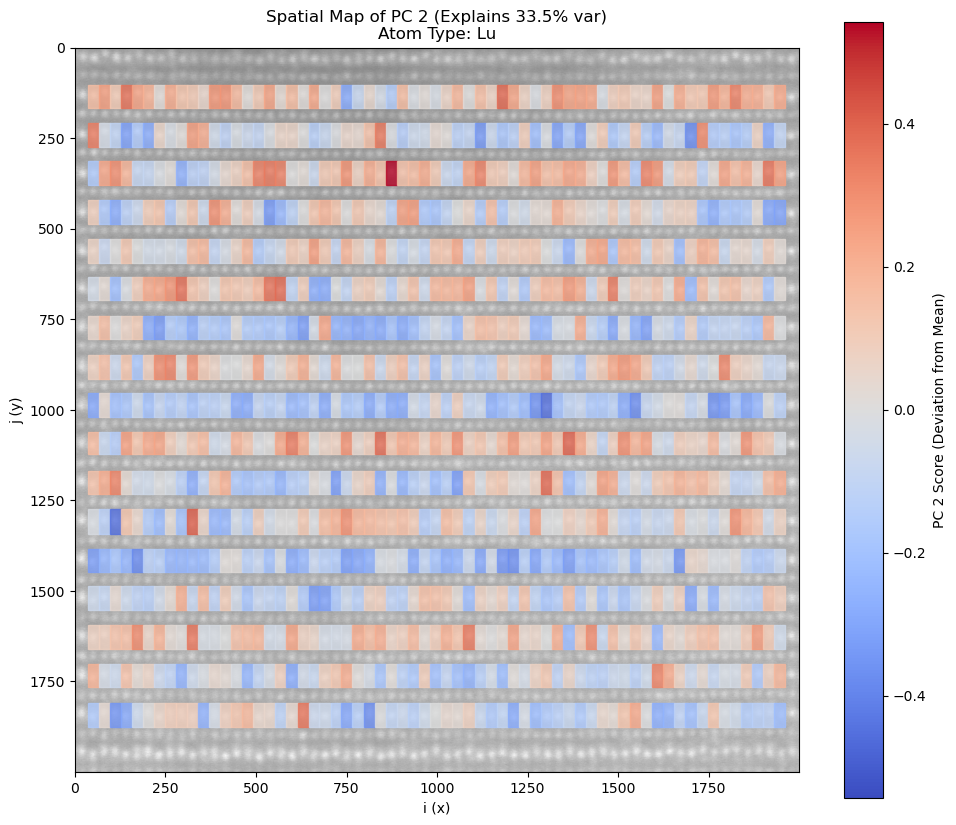

In [9]:
plot_pca_grid(crop, pc_component=2, atom_type='Lu')

/var/folders/_w/v56drf556mx31xc17rw2g1yh0000gn/T/ipykernel_23813/234458908.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


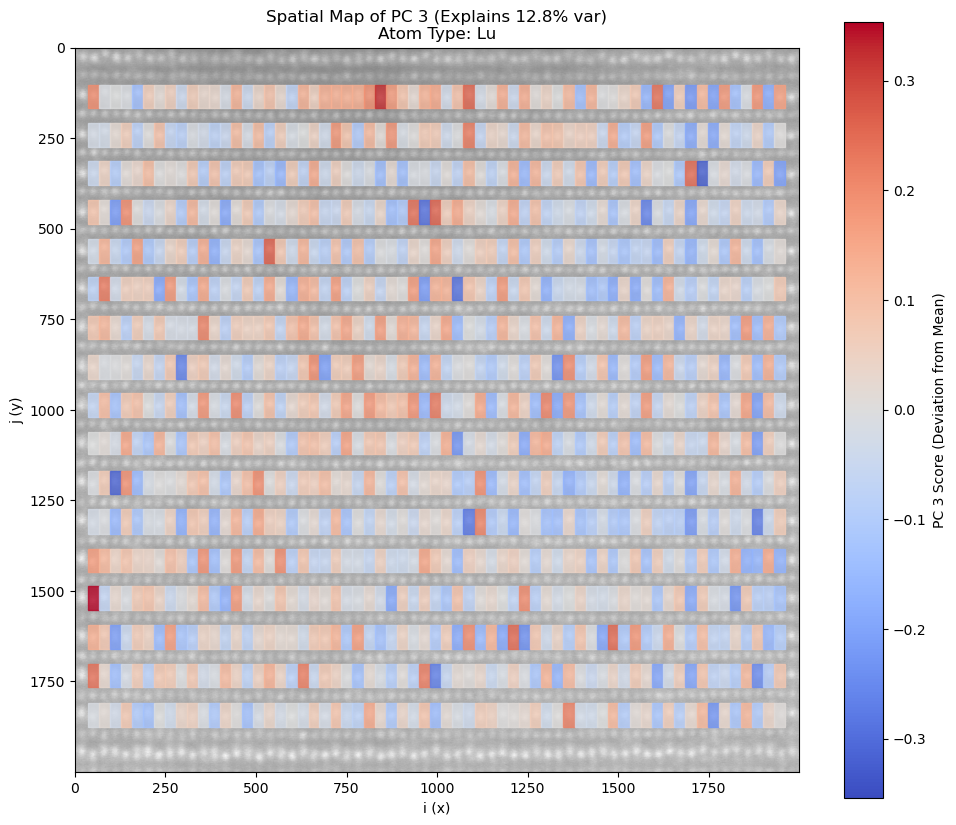

In [10]:
plot_pca_grid(crop, pc_component=3, atom_type='Lu')

/var/folders/_w/v56drf556mx31xc17rw2g1yh0000gn/T/ipykernel_23813/234458908.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


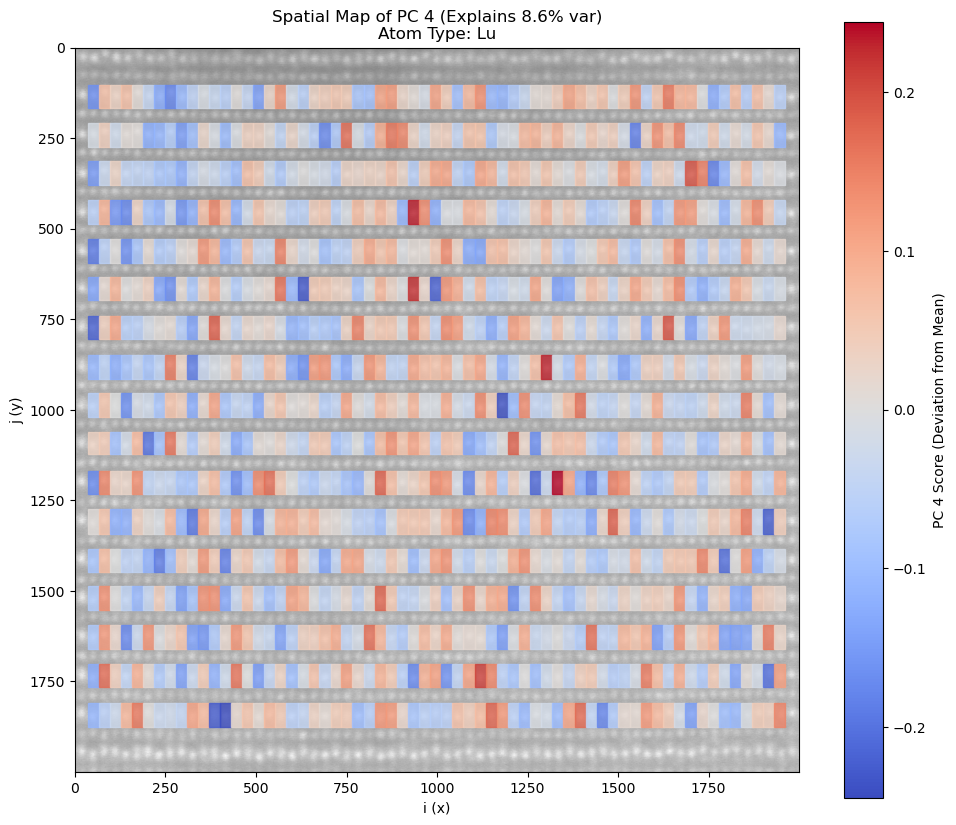

In [11]:
plot_pca_grid(crop, pc_component=4, atom_type='Lu')